In [29]:
import numpy as np
import matplotlib.pyplot as plt
import ctypes as c 
import tqdm
import pickle

import swimAD2 as ad2       # copy swimAD2.py to your working directory
import time

ad2.disconnect()            # close all instances before connecting
zoroku = ad2.connect(0)      # connect to first(0th) ad2, give it the name 'zoroku'

In [30]:
# Set the measurement parameters. 

res1 = 1000 # Values of the resistances in Ohms. 
res2 = 1000.8

def prepare_measurement(inpt,hertz,points,settingoffset):
    ad2.config_wavegen(
        zoroku,                                    # name of device
        frequency=1,                           # max 10 MHz
        amplitude=inpt,                              # max 5 V
        signal_shape=ad2.dwfc.funcSine,         # output signal shape: funcSine, funcSquare, funcTriangle, funcRampUp, funcRampDown, funcNoise
        offset=settingoffset,                               # signal voltage offset
        # phase=0,                                # signal phase
        # symmetry=50,                            # signal symmetry shape
        # channel=0                               # channel 0 / 1 (or -1 for all channels)
    )
    ad2.config_oscilloscope(
        zoroku,                        # name of device
        range0=20,                     # Oscilloscope Channel 0 voltage range, max 25 V
        range1=20,                     # Oscilloscope Channel 2
        sample_rate=hertz,           # max 100 MHz
        sample_size=points,           # max 8192, sample time = sample_size / sample_rate
        )
    return


In [31]:
# Create the np.array of input voltages

n_volt = np.linspace(3.1,5,num=20)
input_dict = {}
for volt in n_volt:
    input_dict[round(volt,2)] = []
print('testing voltage is',n_volt)

# Perform the measurement

hertz=80000 # Frequency of detections by Zoroku in Hz, max 100MHz.
samp_time = 0.1 # Duration of our measurement in s. 
n_trial = range(0,1) # Number of trials per voltage. 
print('sampling frequency is', hertz,'Hz')
points=int(hertz*samp_time)
if points > 8192:
    print("OverflowError") # Activates over maximum resolution. 
    points = 8192
print(points)

for volt in n_volt:
    for i in n_trial: # Specify the number of trials per voltage.
        #print('in', volt, 'V','trial number is',i+1)
        prepare_measurement(0,hertz,points,volt)
        ad2.start_wavegen(zoroku,channel=0)

        # Cheong SY. gives time to stabilise the signal, 
        # but we shall ignore this step and analyse the impact of this.
        time.sleep(1)

        t, v0, v1 = ad2.measure_oscilloscope(zoroku)
        voltage = volt*np.ones(np.size(t))
        a = np.array([v0,v1])
        output = np.transpose(a)
        input_dict[round(volt,2)]=output
        ad2.stop_wavegen(zoroku, channel=0)
with open("step1_ex0_res_"+str(res2)+'.pkl',"wb") as handle:
    pickle.dump(input_dict,handle,protocol=pickle.HIGHEST_PROTOCOL)


testing voltage is [3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8
 4.9 5. ]
sampling frequency is 80000 Hz
8000


{3.1: array([[1.56784914, 1.55988391],
       [1.56784914, 1.55614871],
       [1.56784914, 1.55988391],
       ...,
       [1.56784914, 1.55988391],
       [1.56784914, 1.55988391],
       [1.56784914, 1.55614871]]), 3.2: array([[1.620221  , 1.60844143],
       [1.620221  , 1.60844143],
       [1.61648015, 1.60844143],
       ...,
       [1.620221  , 1.60470624],
       [1.61648015, 1.60844143],
       [1.61648015, 1.60844143]]), 3.3: array([[1.66885201, 1.65699895],
       [1.66885201, 1.65699895],
       [1.66885201, 1.65699895],
       ...,
       [1.66885201, 1.65326376],
       [1.66885201, 1.65326376],
       [1.66885201, 1.65699895]]), 3.4: array([[1.71748302, 1.70182128],
       [1.72122386, 1.70555647],
       [1.71748302, 1.70555647],
       ...,
       [1.71748302, 1.70555647],
       [1.71748302, 1.70555647],
       [1.71748302, 1.70555647]]), 3.5: array([[1.76985487, 1.75411399],
       [1.76611403, 1.75411399],
       [1.76611403, 1.75411399],
       ...,
       [1.76985

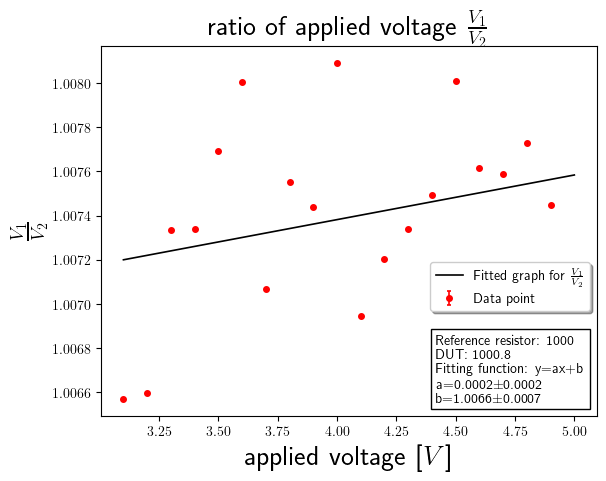

In [32]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib
with open("step1_ex0_res_"+str(res2)+'.pkl',"rb") as handle:
    A = pickle.load(handle)
print(A)
n = len(A)      # number of voltage
m = len(A.get(list(A.keys())[0]))       # number of measurement in each voltage
print(n,m)
B = {}       # temporary storage
C = []       # [input voltage, V1/V2, 1 sigma error]
for i in range(n):      
    mean = np.mean(A.get(list(A.keys())[i]), axis = 0)      # generate list[mean of V_1, mean of V_2]
    std = np.var(A.get(list(A.keys())[i]), axis = 0, ddof = 1)/(m**0.5)      # generate list[sample standard deviation of V_1, sample standard deviation of V_2]
    B[list(A.keys())[i]] = [[mean[0], std[0]], [mean[1], std[1]]]       # generate pair input voltage : list[[mean_V1, SSD_V1], [mean_V2, SSD_V2]]
    #C[list(A.keys())[i]] = [mean[0]/mean[1], mean[0]/mean[1]*((std[0]/mean[0])**2+(std[1]/mean[1])**2)**0.5]         # generate pair input voltage : [V_1/V_2, 1 sigma error]
    C.append([list(A.keys())[i], mean[0]/mean[1], mean[0]/mean[1]*((std[0]/mean[0])**2+(std[1]/mean[1])**2)**0.5])
print(C)
D = np.array(C).T
print(D)
x = D[0]
y = D[1]
stdv = D[2]

def func(x, A, B):
    return A*x+ B

popt, pcov = curve_fit(func, x, y)
print("params:\n", popt)
print("covariance:\n", pcov)
a, b= popt[0], popt[1]
yfit = a*x+b
max = list(A.keys())[-1]
fig, ax = plt.subplots()
ax.plot(x, func(x, a, b),
    linestyle="-",
    linewidth=1.2,
    color="k",
    label=r"Fitted graph for $\frac{V_1}{V_2}$")

ax.errorbar(x, y, yerr=stdv,
    marker='o',
    markersize=4,
    linestyle="None",
    elinewidth=1.2,
    capsize=1.5,
    capthick=1.2,
    color="r",
    label="Data point")
textstr = 'Reference resistor: '+str(res1)+'\nDUT: '+str(res2)+'\nFitting function: y=ax+b'+'\na='+str(round(popt[0], 4))+r'$\pm$'+str(round(pcov[0][0]**0.5, 4))+'\nb='+str(round(popt[1], 4))+r'$\pm$'+str(round(pcov[1][1]**0.5, 4))
textbox = matplotlib.offsetbox.AnchoredText(textstr, loc='lower right')
ax.add_artist(textbox)

plt.rc('text', usetex = True)
#plt.xkcd()
plt.title(r'ratio of applied voltage $\frac{V_1}{V_2}$', fontsize = 20)

plt.ylabel(r'$\frac{V_1}{V_2}$', fontsize = 20)
plt.xlabel(r'applied voltage [$V$]', fontsize = 20)
plt.legend(loc='center right', bbox_to_anchor=(1, 0.35) ,fancybox=True, shadow=True)
plt.grid(False)
plt.savefig("step1_ex0_res_"+str(res2)+'.png')
plt.show()
